<h1><b>Import Required Tools

In [5]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
import tensorflow as tf

from IPython import display

<h1><b>Load and Preprocess Data </h1></b>

In [ ]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

In [ ]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [ ]:
train_images.shape

(60000, 28, 28, 1)

In [ ]:
len(train_images)

60000

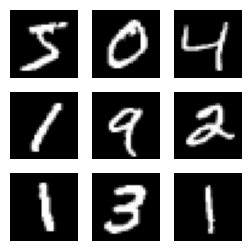

In [ ]:
# Visualize the first 9 images
plt.figure(figsize=(3, 3))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(train_images[i].reshape(28, 28), cmap='gray')
    plt.axis('off')
plt.show()


In [ ]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [ ]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

<h1><b>Defining Model Architectures

In [8]:
import tensorflow as tf

def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())


    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

gen = make_generator_model()
gen.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_7 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_7 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_8 (Bat  (None, 7, 7, 128)        

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        tf.keras.layers.LeakyReLU(),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    return model


In [11]:
discriminator = make_discriminator_model()
discriminator.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_3 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_1 (Flatten)         (None, 6272)             

In [ ]:
!pip install visualkeras

In [ ]:
import visualkeras as visual
from collections import defaultdict

color_map = defaultdict(dict)
color_map[layers.Conv2D]['fill'] = '#00f5d4'
color_map[layers.MaxPooling2D]['fill'] = '#8338ec'
color_map[layers.Dropout]['fill'] = '#03045e'
color_map[layers.Dense]['fill'] = '#fb5607'
color_map[layers.Flatten]['fill'] = '#ffbe0b'

In [ ]:
generator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 12544)             1254400   
                                                                 
 batch_normalization_6 (Bat  (None, 12544)             50176     
 chNormalization)                                                
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 12544)             0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose_6 (Conv2D  (None, 7, 7, 128)         819200    
 Transpose)                                                      
                                                                 
 batch_normalization_7 (Bat  (None, 7, 7, 128)        

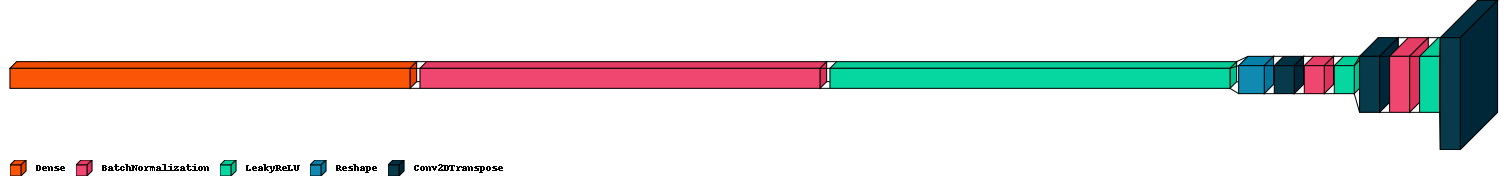

In [ ]:
visual.layered_view(generator,
                    legend = True,
                    color_map = color_map)

In [ ]:
discriminator.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_13 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 7, 7, 128)         0         
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten_2 (Flatten)         (None, 6272)             

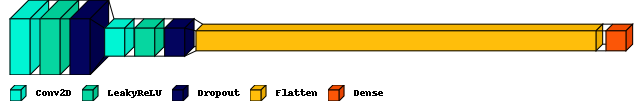

In [ ]:
visual.layered_view(discriminator,
                     legend = True,
                     color_map = color_map)

<h1><b>Customed Loss Functions for Generator and Discriminator

In [ ]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [ ]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(real_output >= 0.5, tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(fake_output < 0.5, tf.float32))
    return (real_accuracy + fake_accuracy) / 2.0

In [ ]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [ ]:
EPOCHS = 50
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])

<h1><b>Training Loop

In [ ]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss, real_output, fake_output


In [ ]:
generator_losses = []
discriminator_losses = []
real_outs = []
fake_outs = []

def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        gen_epoch_loss = []
        disc_epoch_loss = []
        real_out_epoch = []
        fake_out_epoch = []

        for image_batch in dataset:
            gen_loss, disc_loss, real_output, fake_output = train_step(image_batch)
            gen_epoch_loss.append(gen_loss)
            disc_epoch_loss.append(disc_loss)
            real_out_epoch.extend(real_output.numpy().flatten())
            fake_out_epoch.extend(fake_output.numpy().flatten())

        generator_losses.append(np.mean(gen_epoch_loss))
        discriminator_losses.append(np.mean(disc_epoch_loss))
        real_outs.append(np.mean(real_out_epoch))
        fake_outs.append(np.mean(fake_out_epoch))

        # Produce images for the GIF as you go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        print('Time for epoch {} is {} sec'.format(epoch + 1, time.time() - start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)


In [ ]:
def generate_and_save_images(model, epoch, test_input):
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

  return predictions

In [ ]:
import warnings
warnings.filterwarnings('ignore')

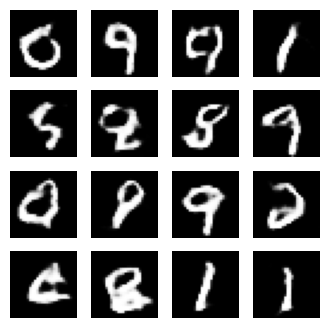

In [ ]:
train(train_dataset, EPOCHS)

<h1><b> Visualising Predictions

In [ ]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

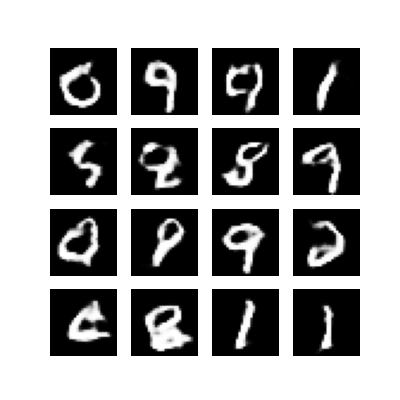

In [ ]:
display_image(EPOCHS)

In [ ]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

In [ ]:
!pip install tensorflow_docs

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 1.8 MB/s eta 0:00:00



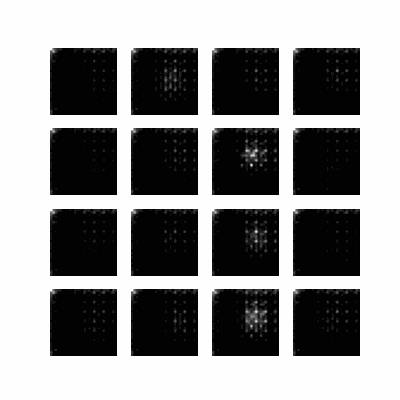

In [ ]:
import tensorflow_docs.vis.embed as embed
embed.embed_file(anim_file)

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np
# x = np.arange(0, 50, 1)

# plt.figure(figsize=(15, 3))
# plt.plot(x,  discriminator_accuracies, marker='o', linestyle='-', color='blue', label='D_accuracy')

# plt.xlabel('Epoch')
# plt.ylabel('Metric')
# plt.title('Evaluation of GAN on MNIST', fontweight='bold')
# plt.legend()
# # plt.savefig('D Accuracy.png')

# plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
x = np.arange(0, 50, 1)

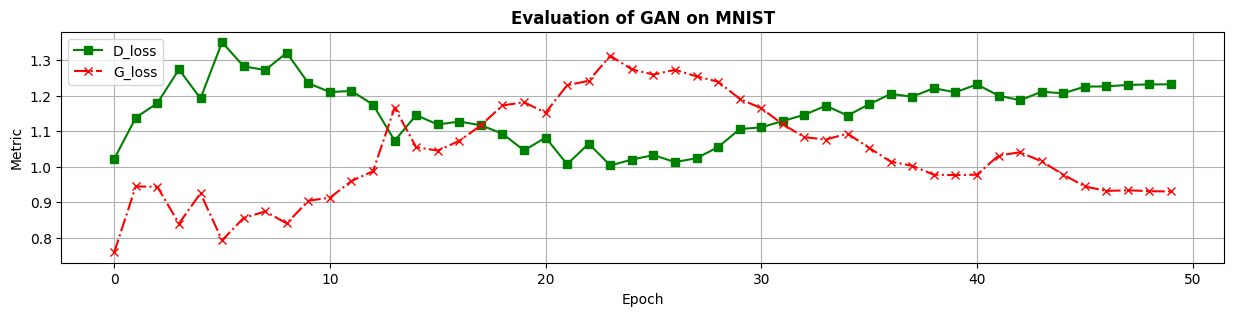

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(x, discriminator_losses, marker='s', linestyle='-', color='green', label='D_loss')
plt.plot(x, generator_losses, marker='x', linestyle='-.', color='red', label='G_loss')

plt.xlabel('Epoch')
plt.ylabel('Metric')
plt.title('Evaluation of GAN on MNIST', fontweight='bold')
plt.legend()
plt.grid()
# plt.savefig('D and G Loss.png')
plt.show()

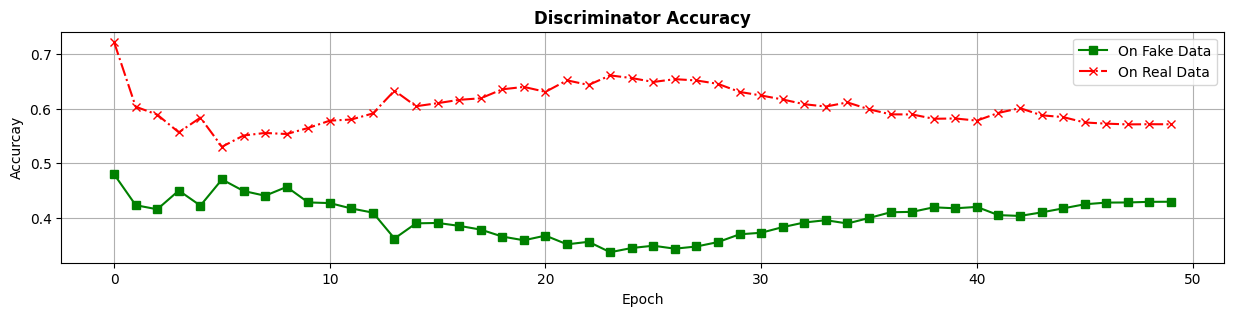

In [ ]:
plt.figure(figsize=(15, 3))
plt.plot(x, fake_outs, marker='s', linestyle='-', color='green', label='On Fake Data')
plt.plot(x, real_outs, marker='x', linestyle='-.', color='red', label='On Real Data')

plt.xlabel('Epoch')
plt.ylabel('Accurcay')
plt.title('Discriminator Accuracy', fontweight='bold')
plt.legend()
plt.grid()
# plt.savefig('D and G Loss.png')
plt.show()